# MZmine-SIRIUS workflow

This workflow is designed to work with data preprocessed with MZmine and SIRIUS (CANOPUS):
1- Determine the number of features per sample
2- Obtain the proportion of features per Pathway NPC-taxonomy or Superclass ClassyFire-taxonomy per sample.
3- Obtain the proportion of features per Superclass NPC-taxonomy or Class ClassyFire-taxonomyper sample.
4- Obtain the proportion of features per Class NPC-taxonomy or SubClass ClassyFire-taxonomy per sample.
5- Do the above by grouping the replicas

# Requirements
1-Quant file (.csv)
2-Canopus_compound_summary file (.tsv)
3-Metadata file (.txt, columne filename and columne ATTRIBUTE)

# Load packages

In [ ]:
# Load packages
install.packages(c("svglite","readr","fuzzyjoin", "tidyverse", "readxl", "openxlsx", "dplyr","stringr", "tidyr","ggplot2", "writex1", "UpSetR","Cairo"))
library(svglite)
library(fuzzyjoin)
library(tidyverse)
library(readxl)
library(openxlsx)
library(readr)
library(dplyr)
library(stringr)
library(tidyr)
library(ggplot2)
library(stringr)
library(writexl)
library(UpSetR)
library(Cairo)

# Part 1

## Load data
change the name as appropriate

In [3]:
# load Quant File
options(warn = -1)
# change Quant file name
Quant <- read_csv("Quant_base.csv") %>%
  mutate(`row ID` = as.character(`row ID`)) %>%
  select(-c(`row m/z`, `row retention time`, `row ion mobility`, `row ion mobility unit`, 
            `row CCS`, `correlation group ID`, `annotation network number`, `best ion`, 
            `auto MS2 verify`, `identified by n=`, `partners`, `neutral M mass`))

## Load CANOPUS predictions
# change Canopus file name
Canopus <- read_tsv("canopus_structure_summary.tsv") 
Canopus$mappingFeatureId <- as.character(Canopus$mappingFeatureId)

## Load metadata 
# change Metadata file name
Metadata <- read_delim("Metadata.txt")

New names:
• `` -> `...41`
Rows: 1014 Columns: 41
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): best ion, partners
dbl (34): row ID, row m/z, row retention time, correlation group ID, annotat...
lgl  (5): row ion mobility, row ion mobility unit, row CCS, auto MS2 verify,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2059 Columns: 28
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): molecularFormula, adduct, precursorFormula, NPC#pathway, NPC#super...
dbl (15): formulaRank, NPC#pathway Probability, NPC#superclass Probability, ...
lgl  (1): overallFeatureQuality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_t

# Part 2
## Number of features per sample

## Run the workflow to obtain the plot (Download from plot folder)

pdf 
  2

pdf 
  2

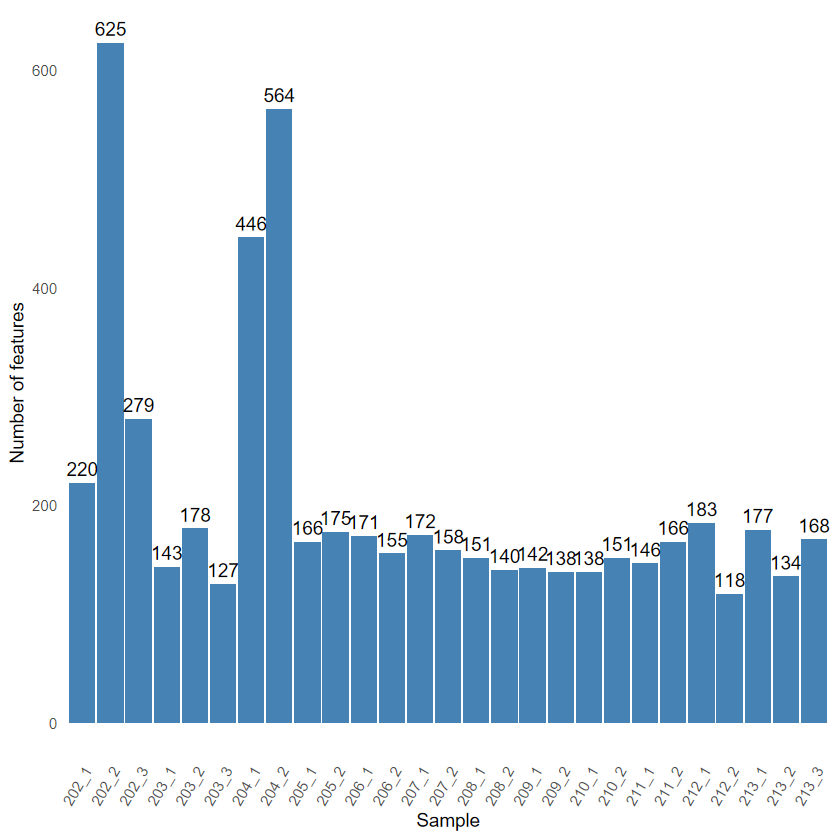

In [ ]:
# Function to obtain the columns in which a feature is present
get_present_samples <- function(feature_row) {
  present_samples <- names(feature_row)[!is.na(feature_row) & feature_row != 0]
  paste(unique(present_samples), collapse = ", ")
}

# Create dataframe with results
Feature_per_sample <- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")))

# Separate the `samples` column into individual rows
Feature_per_sample_long <- Feature_per_sample %>%
  separate_rows(samples, sep = ",")%>%
  mutate(samples = str_trim(samples)) 


# Count the amount of precursors per sample.
Feature_sample <- Feature_per_sample_long %>%
  group_by(samples) %>%
  summarise(count = n())


# plot
plot=ggplot(Feature_sample, aes(x = samples, y = count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = count), vjust = -0.5, color = "black") +
  labs(x = "Sample",
       y = "Number of features") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())+
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Create the 'plot' folder if it does not exist
if (!dir.exists("plot")) {
  dir.create("plot")
}

# Save the plot in the 'plot' folder
ggsave("plot/features_sample.png", plot = plot, width = 10, height = 6)
ggsave("plot/features_sample.svg", plot = plot, width = 10, height = 6, device = "svg")

# Considering replicates 

Quant_metadata <- Quant
colnames(Quant_metadata)[2:ncol(Quant_metadata)] <- sapply(colnames(Quant_metadata)[2:ncol(Quant_metadata)], function(x) 
  paste(sub(" .*", "", x), collapse = ","))
col_names <- colnames(Quant_metadata)[-1]
name_map <- setNames(Metadata$ATTRIBUTE_Sample, Metadata$Filename)
new_col_names <- ifelse(col_names %in% names(name_map), name_map[col_names], col_names)
colnames(Quant_metadata)[-1] <- new_col_names

# Create dataframe with results
Feature_per_sample_Metadata <- data.frame(
  Precursor = Quant_metadata$`row ID`,  
  samples = sapply(apply(Quant_metadata[, 2:ncol(Quant_metadata)], 1, get_present_samples), function(x) paste(x, collapse = ","))
)

# Separate the `samples` column into individual rows
Feature_per_sample_Metadata_long <- Feature_per_sample_Metadata %>%
  separate_rows(samples, sep = ",")%>%
  mutate(samples = str_trim(samples)) 


# Count the amount of precursors per sample.
Feature_sample_Metadata <- Feature_per_sample_Metadata_long %>%
  group_by(samples) %>%
  summarise(count = n())


# plot
Features_per_sample_metadata_plot=ggplot(Feature_sample_Metadata, aes(x = samples, y = count)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = count), vjust = -0.5, color = "black") +
  labs(x = "Sample",
       y = "Number of features") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())+
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")


# Save the plot in the 'plot' folder
ggsave("plot/features_sample_Metadata.png", plot = Features_per_sample_metadata_plot, width = 10, height = 6)
ggsave("plot/features_sample_Metadata.svg", plot = Features_per_sample_metadata_plot, width = 10, height = 6, device = "svg")


#upsetplot

df_upsetplot <- strsplit(as.character(Feature_per_sample_Metadata$samples), ",")
names(df_upsetplot) <- Feature_per_sample_Metadata$Precursor
unique_samples <- unique(unlist(df_upsetplot))
presence_matrix <- do.call(rbind, lapply(df_upsetplot, function(x) {
  as.numeric(unique_samples %in% x)
}))
colnames(presence_matrix) <- unique_samples
presence_df <- as.data.frame(presence_matrix)

Upsetplot <- upset(
  presence_df, 
  sets = colnames(presence_df), 
  order.by = "freq", 
  main.bar.color = "#2F4F4F",          # Color de las barras principales
  sets.bar.color = "#68838B",           # Color de las barras de los conjuntos
  matrix.color = "#8B5742",           # Color de la matriz de puntos
  shade.color = "white",               # Color del sombreado en la matriz
  set_size.show = TRUE,                 # Mostrar el tamaño de los conjuntos
)

CairoPNG("plot/Upsetplot.png", width = 800, height = 600)
print(Upsetplot)
dev.off()
CairoSVG("plot/Upsetplot.svg", width = 8, height = 6)
print(Upsetplot)
dev.off()
    

plot    
Features_per_sample_metadata_plot
Upsetplot    

# Part 3
## Proportion of Pathway NPC-taxomy and Superclass ClassyFire-taxonomy per sample

In [4]:
# Custom color palette
custom_color_palette <- c(
  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666",
  "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
  "#e41a1c", "#8B8878", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c",
  "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
)

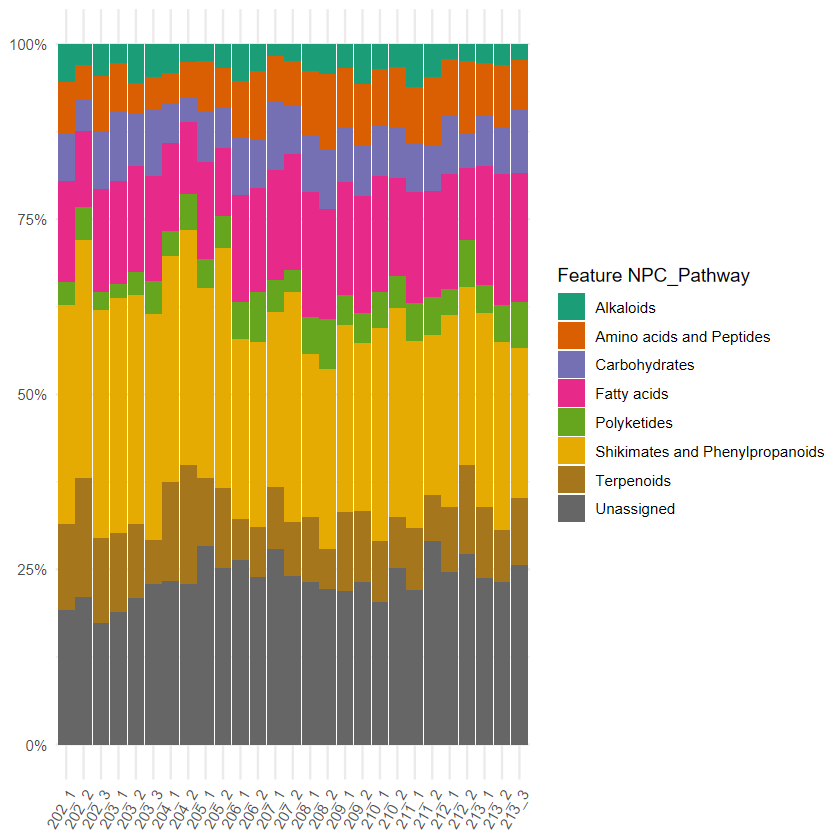

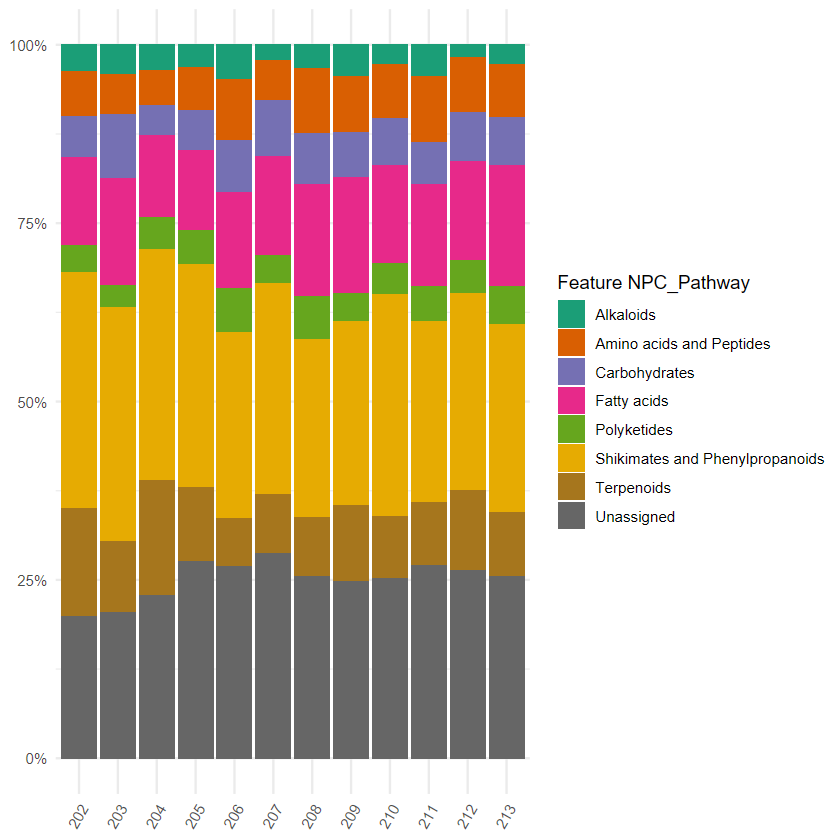

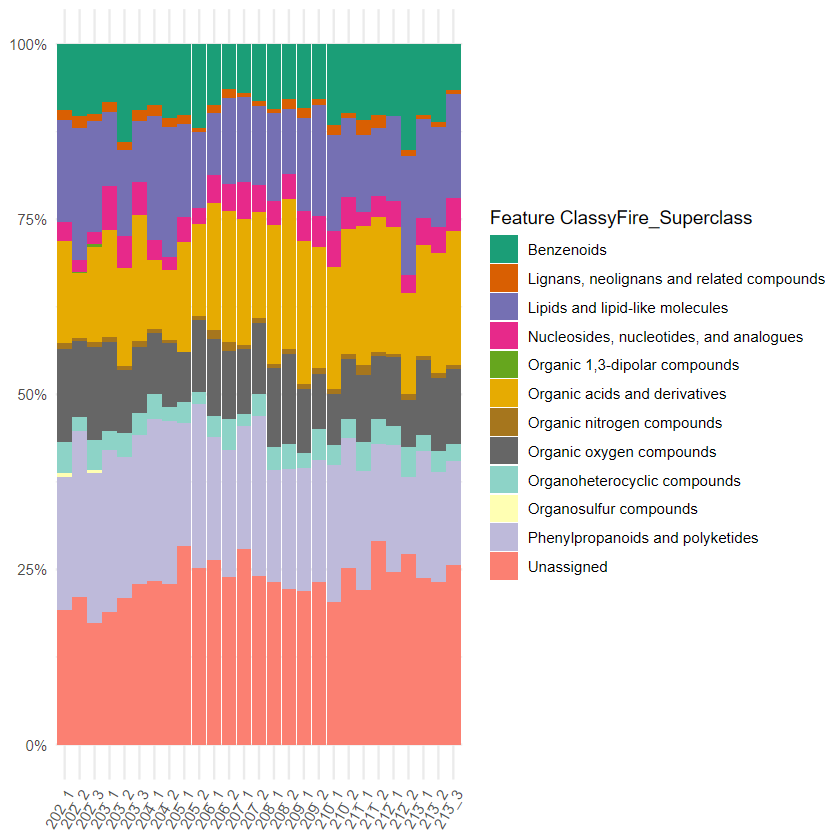

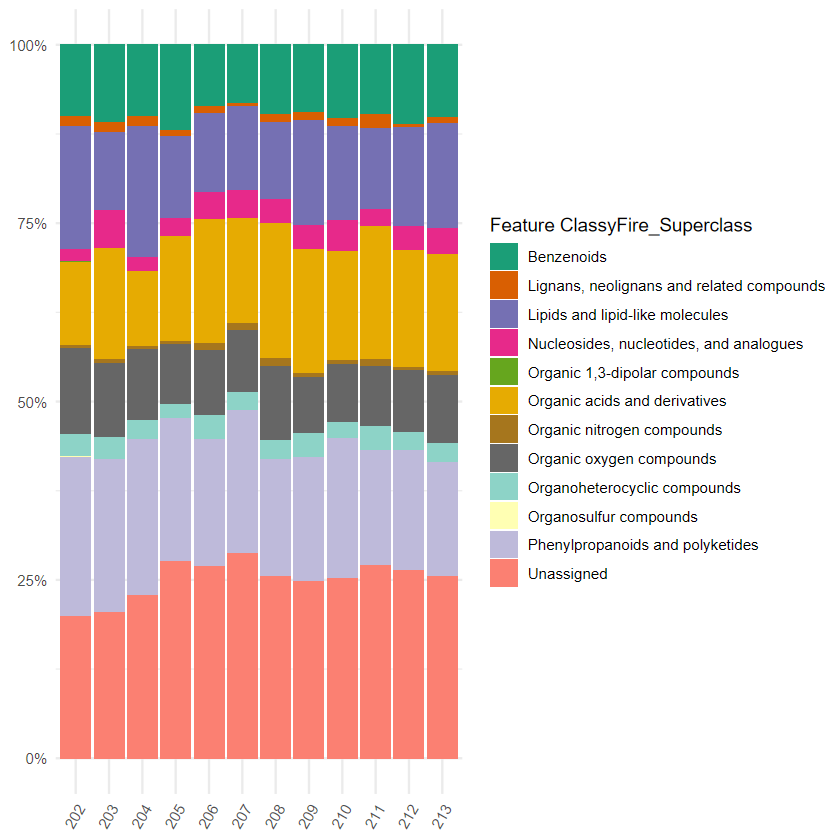

In [10]:

Quant_canopus_pathway <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#superclass`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_pathway <- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  NPC_pathway = Quant_canopus_pathway$`NPC#pathway`
)
Feature_per_sample_pathway[is.na(Feature_per_sample_pathway)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_pathway  <- Feature_per_sample_pathway %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(NPC_pathway = ifelse(NPC_pathway %in% (Feature_per_sample_pathway %>%
                                                  count(NPC_pathway) %>%
                                                  top_n(15, wt = n) %>%
                                                  pull(NPC_pathway)), NPC_pathway, "Others")) %>%
  group_by(samples, NPC_pathway) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
pathway_sample = ggplot(Feature_per_sample_long_pathway, aes(x = samples, y = prop, fill = NPC_pathway)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_Pathway", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_pathway_sample.png", plot = pathway_sample, width = 10, height = 6)
ggsave("plot/proportion_pathway_sample.svg", plot = pathway_sample, width = 10, height = 6, device = "svg")

# CLassyFire

Quant_canopus_superclass_CF <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#superclass`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`NPC#pathway`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#all classifications`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_superclass_CF <- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  CF_superclass = Quant_canopus_superclass_CF$`ClassyFire#superclass`
)
Feature_per_sample_superclass_CF[is.na(Feature_per_sample_superclass_CF)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_superclass_CF  <- Feature_per_sample_superclass_CF %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(CF_superclass = ifelse(CF_superclass %in% (Feature_per_sample_superclass_CF %>%
                                                  count(CF_superclass) %>%
                                                  top_n(15, wt = n) %>%
                                                  pull(CF_superclass)), CF_superclass, "Others")) %>%
  group_by(samples, CF_superclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_superclass_sample = ggplot(Feature_per_sample_long_superclass_CF, aes(x = samples, y = prop, fill = CF_superclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_Superclass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_superclass_sample.png", plot = CF_superclass_sample, width = 10, height = 6)
ggsave("plot/proportion_CF_superclass_sample.svg", plot = CF_superclass_sample, width = 10, height = 6, device = "svg")

    
# Proportion pathway per sample considering metadata

Quant_canopus_pathway_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#superclass`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_pathway_metadata <- Quant_canopus_pathway_metadata %>%
  rename(NPC_pathway = `NPC#pathway`)
Quant_canopus_pathway_metadata[is.na(Quant_canopus_pathway_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_pathway_metadata  <- Quant_canopus_pathway_metadata %>%
  mutate(NPC_pathway = ifelse(NPC_pathway %in% (Quant_canopus_pathway_metadata %>%
                                                  count(NPC_pathway) %>%
                                                  top_n(25, wt = n) %>%
                                                  pull(NPC_pathway)), NPC_pathway, "Others")) %>%
  group_by(samples, NPC_pathway) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
pathway_sample_Metadata = ggplot(Feature_per_sample_long_pathway_metadata, aes(x = samples, y = prop, fill = NPC_pathway)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_Pathway", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_pathway_sample_metadata.png", plot = pathway_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_pathway_sample_metadata.svg", plot = pathway_sample_Metadata, width = 10, height = 6, device = "svg")


#ClassyFire

Quant_canopus_CF_superclass_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#superclass`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`NPC#pathway`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_CF_superclass_metadata <- Quant_canopus_CF_superclass_metadata %>%
  rename(CF_superclass = `ClassyFire#superclass`)
Quant_canopus_CF_superclass_metadata[is.na(Quant_canopus_CF_superclass_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_CF_superclass_metadata  <- Quant_canopus_CF_superclass_metadata %>%
  mutate(CF_superclass = ifelse(CF_superclass %in% (Quant_canopus_CF_superclass_metadata %>%
                                                  count(CF_superclass) %>%
                                                  top_n(25, wt = n) %>%
                                                  pull(CF_superclass)), CF_superclass, "Others")) %>%
  group_by(samples, CF_superclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_superclass_sample_Metadata = ggplot(Feature_per_sample_long_CF_superclass_metadata, aes(x = samples, y = prop, fill = CF_superclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_Superclass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_superclass_sample_metadata.png", plot = CF_superclass_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_CF_superclass_sample_metadata.svg", plot = CF_superclass_sample_Metadata, width = 10, height = 6, device = "svg")    

pathway_sample
pathway_sample_Metadata
CF_superclass_sample
CF_superclass_sample_Metadata

# Part 4
## Proportion of Superclass NPC-taxonomy and ClassyFire-taxonomy per sample

In [7]:
# Custom color palette
custom_color_palette <- c(
  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666",
  "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
  "#e41a1c", "#8B8878", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c",
  "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
)

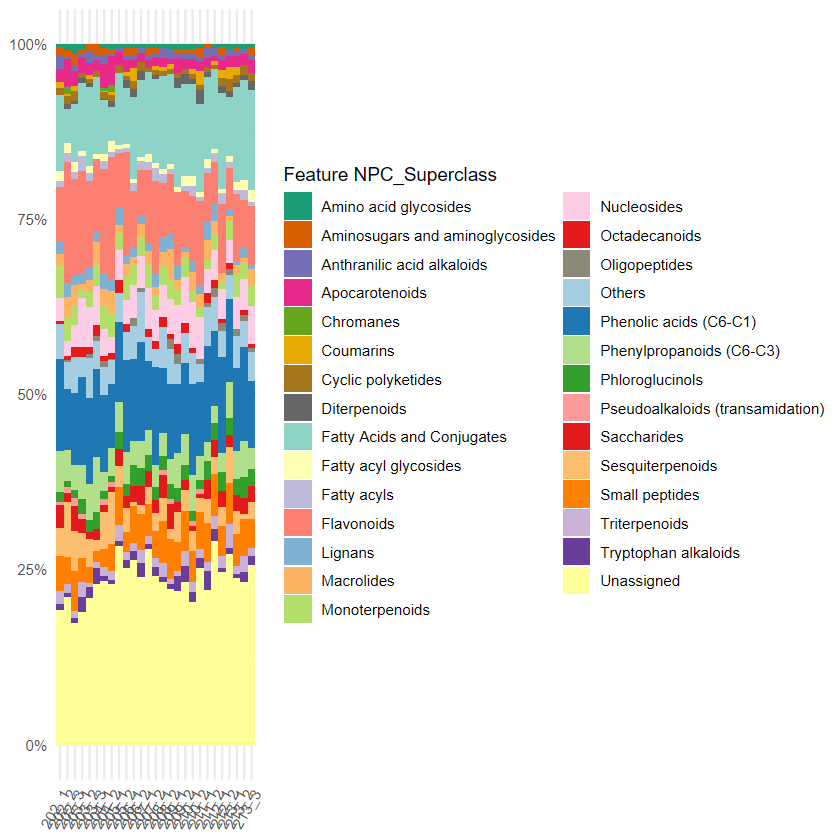

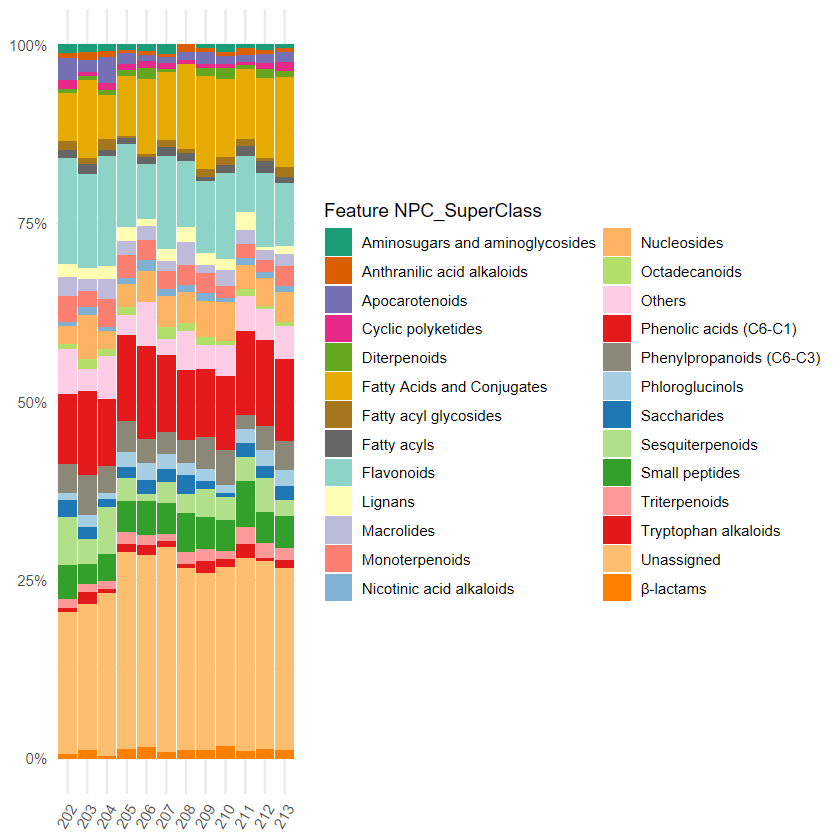

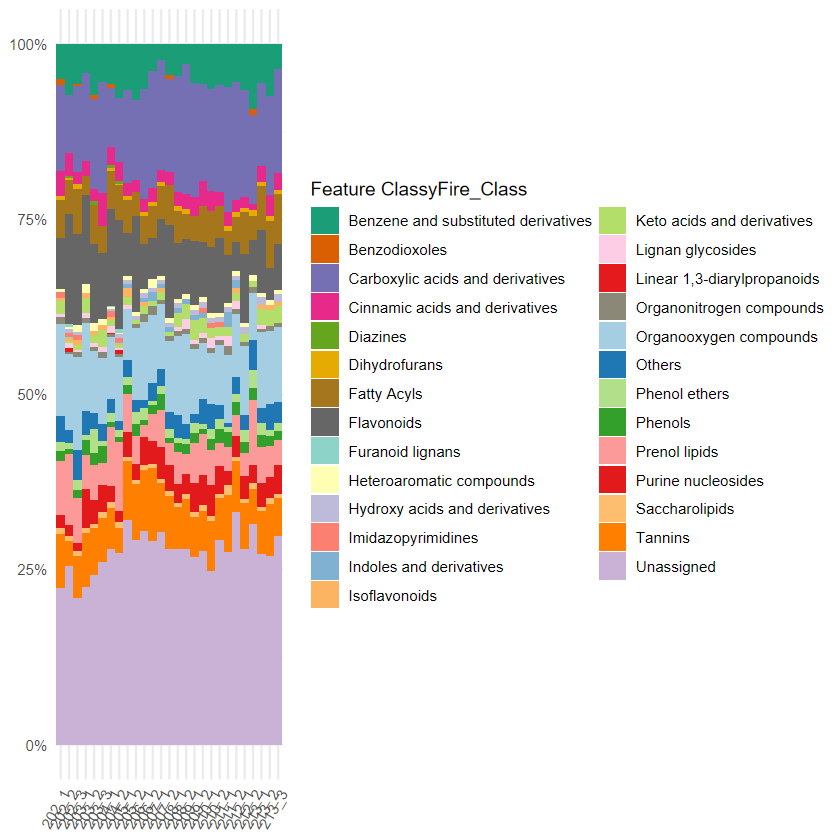

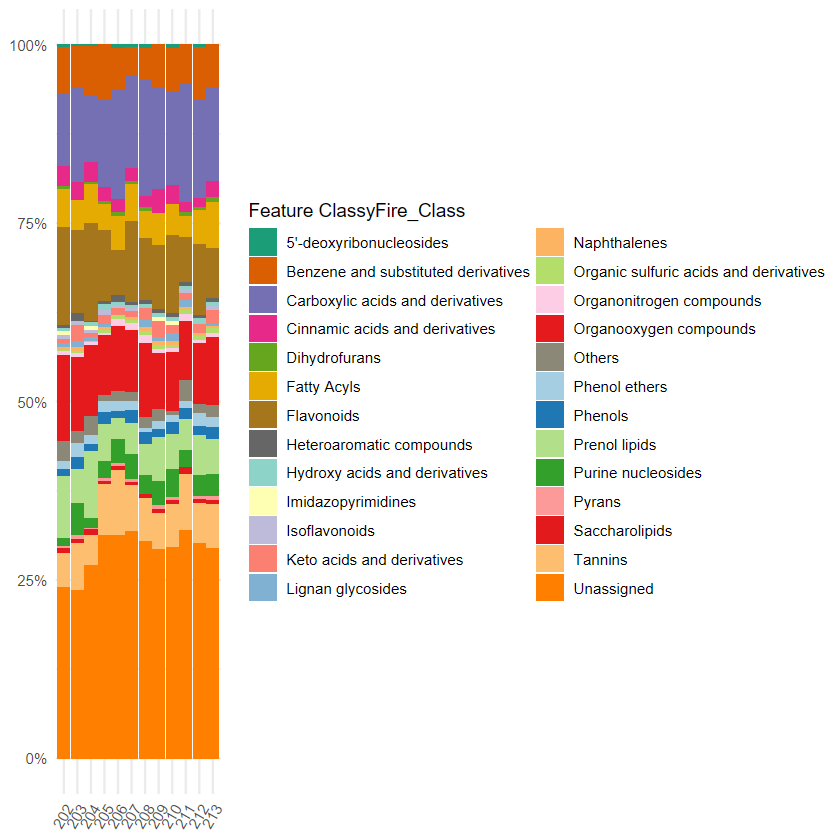

In [9]:
# NPC
Quant_canopus_superclass <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_superclass<- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  NPC_superclass = Quant_canopus_superclass$`NPC#superclass`
)
Feature_per_sample_superclass[is.na(Feature_per_sample_superclass)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_superclass  <- Feature_per_sample_superclass %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(NPC_superclass = ifelse(NPC_superclass %in% (Feature_per_sample_superclass %>%
                                                        count(NPC_superclass) %>%
                                                        top_n(25, wt = n) %>%
                                                        pull(NPC_superclass)), NPC_superclass, "Others")) %>%
  group_by(samples, NPC_superclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
superclass_sample = ggplot(Feature_per_sample_long_superclass, aes(x = samples, y = prop, fill = NPC_superclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_Superclass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_superclass_sample.png", plot = superclass_sample, width = 10, height = 6)
ggsave("plot/proportion_superclass_sample.svg", plot = superclass_sample, width = 10, height = 6, device = "svg")

# ClassyFire
Quant_canopus_CF_class <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#superclass`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_CF_class<- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  CF_class = Quant_canopus_CF_class$`ClassyFire#class`
)
Feature_per_sample_CF_class[is.na(Feature_per_sample_CF_class)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_CF_class  <- Feature_per_sample_CF_class %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(CF_class = ifelse(CF_class %in% (Feature_per_sample_CF_class %>%
                                                        count(CF_class) %>%
                                                        top_n(25, wt = n) %>%
                                                        pull(CF_class)), CF_class, "Others")) %>%
  group_by(samples, CF_class) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_class_sample = ggplot(Feature_per_sample_long_CF_class, aes(x = samples, y = prop, fill = CF_class)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_Class", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_class_sample.png", plot = CF_class_sample, width = 10, height = 6)
ggsave("plot/proportion_CF_class_sample.svg", plot = CF_class_sample, width = 10, height = 6, device = "svg")


#Replicates: NPC
Quant_canopus_superclass_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_superclass_metadata <- Quant_canopus_superclass_metadata %>%
  rename(NPC_superclass = `NPC#superclass`)
Quant_canopus_superclass_metadata[is.na(Quant_canopus_superclass_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_superclass_metadata  <- Quant_canopus_superclass_metadata %>%
  mutate(NPC_superclass = ifelse(NPC_superclass %in% (Quant_canopus_superclass_metadata %>%
                                                  count(NPC_superclass) %>%
                                                  top_n(25, wt = n) %>%
                                                  pull(NPC_superclass)), NPC_superclass, "Others")) %>%
  group_by(samples, NPC_superclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
superclass_sample_Metadata = ggplot(Feature_per_sample_long_superclass_metadata, aes(x = samples, y = prop, fill = NPC_superclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_SuperClass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_superclass_sample_metadata.png", plot = superclass_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_superclass_sample_metadata.svg", plot = superclass_sample_Metadata, width = 10, height = 6, device = "svg")

#Replicates: ClassyFire

Quant_canopus_CF_class_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#superclass`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_CF_class_metadata <- Quant_canopus_CF_class_metadata %>%
  rename(CF_class = `ClassyFire#class`)
Quant_canopus_CF_class_metadata[is.na(Quant_canopus_CF_class_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_CF_class_metadata  <- Quant_canopus_CF_class_metadata %>%
  mutate(CF_class = ifelse(CF_class %in% (Quant_canopus_CF_class_metadata %>%
                                                        count(CF_class) %>%
                                                        top_n(25, wt = n) %>%
                                                        pull(CF_class)), CF_class, "Others")) %>%
  group_by(samples, CF_class) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_class_sample_Metadata = ggplot(Feature_per_sample_long_CF_class_metadata, aes(x = samples, y = prop, fill = CF_class)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_Class", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_class_sample_metadata.png", plot = CF_class_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_CF_class_sample_metadata.svg", plot = CF_class_sample_Metadata, width = 10, height = 6, device = "svg")
    

    
superclass_sample
superclass_sample_Metadata
CF_class_sample
CF_class_sample_Metadata    

# Part 5
## Proportion of Class NPC-taxonomy and SubClass ClassyFire-taxonomy per sample

In [11]:
custom_color_palette <- c(
  "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666",
  "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", "#fdb462", "#b3de69", "#fccde5",
  "#e41a1c", "#8B8878", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c",
  "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928"
)

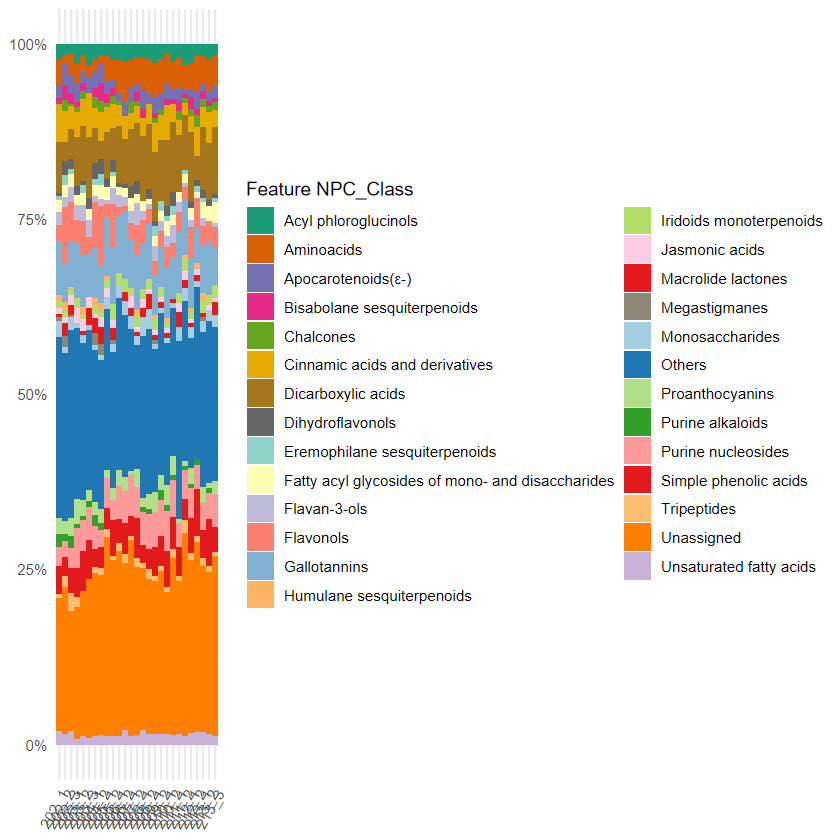

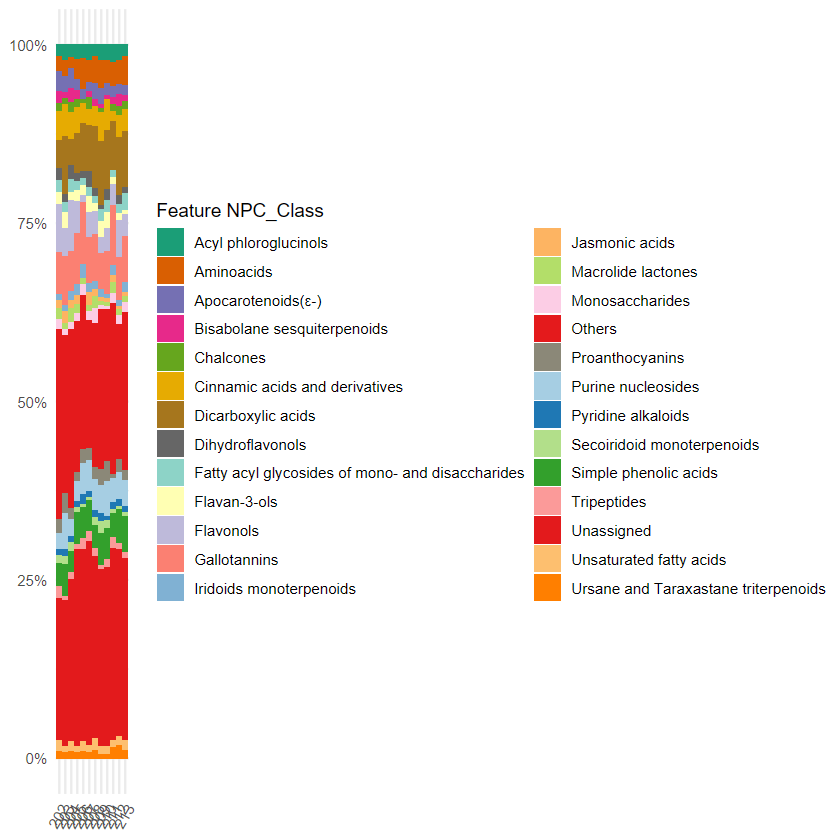

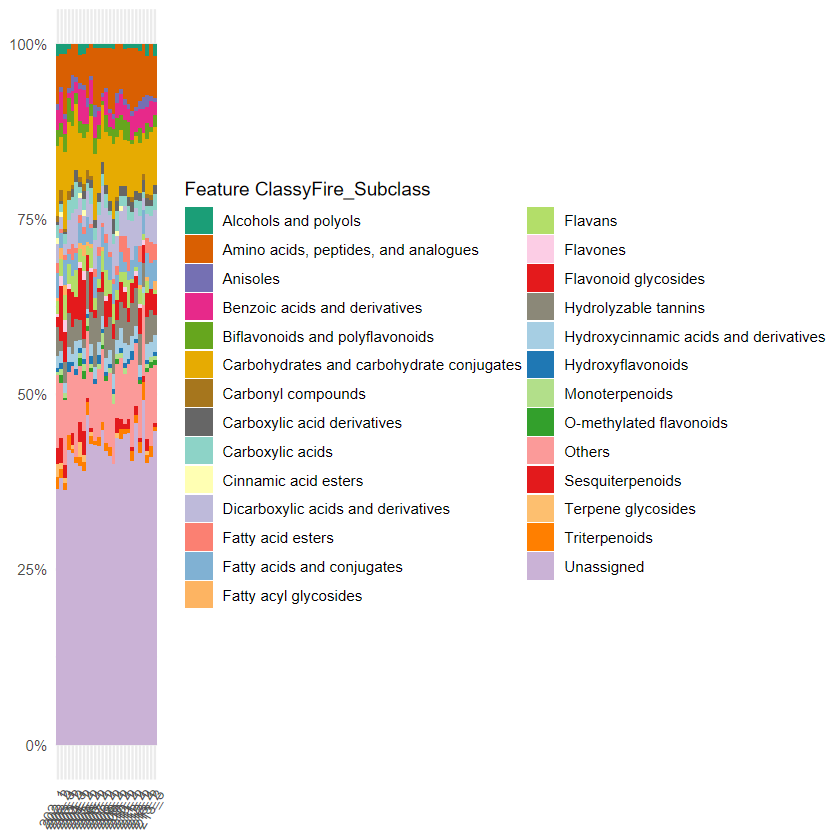

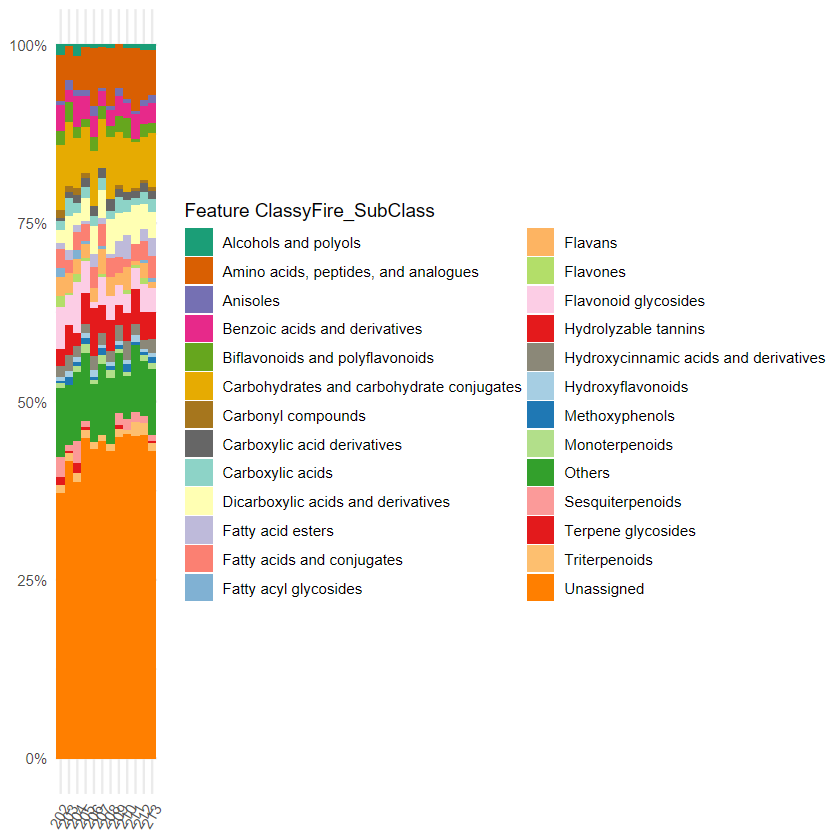

In [13]:
#NPC
Quant_canopus_class <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#superclass`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_class<- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  NPC_class = Quant_canopus_class$`NPC#class`
)
Feature_per_sample_class[is.na(Feature_per_sample_class)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_class  <- Feature_per_sample_class %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(NPC_class = ifelse(NPC_class %in% (Feature_per_sample_class %>%
                                                        count(NPC_class) %>%
                                                        top_n(25, wt = n) %>%
                                                        pull(NPC_class)), NPC_class, "Others")) %>%
  group_by(samples, NPC_class) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
class_sample = ggplot(Feature_per_sample_long_class, aes(x = samples, y = prop, fill = NPC_class)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_Class", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_class_sample.png", plot = class_sample, width = 10, height = 6)
ggsave("plot/proportion_class_sample.svg", plot = class_sample, width = 10, height = 6, device = "svg")

# ClassyFire
Quant_canopus_CF_subclass <- Quant %>%
  left_join(Canopus, by = c("row ID" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)

# Create dataframe with results
Feature_per_sample_CF_subclass<- data.frame(
  Precursor = Quant$`row ID`,
  samples = sapply(apply(Quant[, 2:ncol(Quant)], 1, get_present_samples), 
                   function(x) paste(sub("\\..*", "", unlist(strsplit(x, ","))), collapse = ",")), 
  CF_subclass = Quant_canopus_CF_subclass$`ClassyFire#subclass`
)
Feature_per_sample_CF_subclass[is.na(Feature_per_sample_CF_subclass)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_CF_subclass  <- Feature_per_sample_CF_subclass %>%
  separate_rows(samples, sep = ",") %>%
  mutate(samples = trimws(samples)) %>%
  mutate(CF_subclass = ifelse(CF_subclass %in% (Feature_per_sample_CF_subclass %>%
                                              count(CF_subclass) %>%
                                              top_n(25, wt = n) %>%
                                              pull(CF_subclass)), CF_subclass, "Others")) %>%
  group_by(samples, CF_subclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_subclass_sample = ggplot(Feature_per_sample_long_CF_subclass, aes(x = samples, y = prop, fill = CF_subclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_Subclass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_subclass_sample.png", plot = CF_subclass_sample, width = 10, height = 6)
ggsave("plot/proportion_CF_subclass_sample.svg", plot = CF_subclass_sample, width = 10, height = 6, device = "svg")

# Replicates: NPC    

Quant_canopus_class_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#superclass`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_class_metadata <- Quant_canopus_class_metadata %>%
  rename(NPC_class = `NPC#class`)
Quant_canopus_class_metadata[is.na(Quant_canopus_class_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_class_metadata  <- Quant_canopus_class_metadata %>%
  mutate(NPC_class = ifelse(NPC_class %in% (Quant_canopus_class_metadata %>%
                                                        count(NPC_class) %>%
                                                        top_n(25, wt = n) %>%
                                                        pull(NPC_class)), NPC_class, "Others")) %>%
  group_by(samples, NPC_class) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
class_sample_Metadata = ggplot(Feature_per_sample_long_class_metadata, aes(x = samples, y = prop, fill = NPC_class)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature NPC_Class", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_class_sample_metadata.png", plot = class_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_class_sample_metadata.svg", plot = class_sample_Metadata, width = 10, height = 6, device = "svg")

#Replicates:ClassyFire    
Quant_canopus_CF_subclass_metadata <- Feature_per_sample_Metadata_long %>%
  left_join(Canopus, by = c("Precursor" = "mappingFeatureId")) %>%
  select(   -ionMass, -formulaRank, 
            -formulaId, -alignedFeatureId, -overallFeatureQuality, -retentionTimeInSeconds,
            -retentionTimeInMinutes, -molecularFormula, -adduct, -precursorFormula, -`NPC#pathway`,
            -`NPC#class`, -`NPC#pathway Probability`, -`NPC#superclass Probability`, 
            -`ClassyFire#most specific class`, -`ClassyFire#most specific class Probability`,
            -`ClassyFire#level 5`, -`ClassyFire#level 5 Probability`, -`ClassyFire#superclass probability`, 
            -`ClassyFire#all classifications`, -`ClassyFire#class Probability`, -`ClassyFire#class`, 
            -`ClassyFire#superclass`, -`ClassyFire#subclass Probability`, -`NPC#class Probability`)
Quant_canopus_CF_subclass_metadata <- Quant_canopus_CF_subclass_metadata %>%
  rename(CF_subclass = `ClassyFire#subclass`)
Quant_canopus_CF_subclass_metadata[is.na(Quant_canopus_CF_subclass_metadata)] <- "Unassigned"


# Transforming data to long format for visualization
Feature_per_sample_long_CF_subclass_metadata  <- Quant_canopus_CF_subclass_metadata %>%
  mutate(CF_subclass = ifelse(CF_subclass %in% (Quant_canopus_CF_subclass_metadata %>%
                                              count(CF_subclass) %>%
                                              top_n(25, wt = n) %>%
                                              pull(CF_subclass)), CF_subclass, "Others")) %>%
  group_by(samples, CF_subclass) %>%
  summarise(count = n(), .groups = 'drop') %>%
  group_by(samples) %>%
  mutate(prop = count / sum(count)) %>%
  ungroup() %>%
  mutate(samples = factor(samples, levels = sort(unique(samples))))

# plot
CF_subclass_sample_Metadata = ggplot(Feature_per_sample_long_CF_subclass_metadata, aes(x = samples, y = prop, fill = CF_subclass)) +
  geom_bar(stat = "identity", position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_manual(values = custom_color_palette) +
  labs(fill = "Feature ClassyFire_SubClass", x = NULL, y = NULL) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
  annotate("text", x = Inf, y = Inf, label = "", 
           hjust = 1.1, vjust = 1.1, size = 6, fontface = "bold", color = "black")

# Save the plot in the 'plot' folder'
ggsave("plot/proportion_CF_subclass_sample_metadata.png", plot = CF_subclass_sample_Metadata, width = 10, height = 6)
ggsave("plot/proportion_CF_subclass_sample_metadata.svg", plot = CF_subclass_sample_Metadata, width = 10, height = 6, device = "svg")


    
class_sample
class_sample_Metadata
CF_subclass_sample
CF_subclass_sample_Metadata    